In [1]:
import sys
if "/Users/raymond/code/FinalProject563" not in sys.path:
    sys.path.append("/Users/raymond/code/FinalProject563")
import torch
import pickle
import glob
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas
import time
import os

import connect_four
import mcts
import connect_net
import connect_plot
import evaluation
import utils
import runner
%matplotlib inline
%load_ext autoreload
%autoreload 2
os.chdir("/Users/raymond/code/FinalProject563")

In [20]:

trial = "conv501"
iteration = 1
training_folder = utils.get_training_folder(trial=trial, iteration=iteration)
training_path = utils.get_model_path(folder=training_folder, iteration=iteration)
nnet1 = connect_net.load_model(path=training_path, log=False, klass=connect_net.ConnectNet2)
iteration = 28
training_folder = utils.get_training_folder(trial=trial, iteration=iteration)
training_path = utils.get_model_path(folder=training_folder, iteration=iteration)
nnet51 = connect_net.load_model(path=training_path, log=False, klass=connect_net.ConnectNet2)
# networks = {}
# for i in range(1, 64):
#     iteration = i
#     training_folder = utils.get_training_folder(trial=trial, iteration=iteration)
#     training_path = runner.get_model_path(folder=training_folder, iteration=iteration)
#     nnet = connect_net.load_model(path=training_path, log=False)
#     networks[i] = nnet
# nnetp = connect_net.load_model(path="models/pretrain01.model", log=False)
# networks["p"] = nnetp
# print(len(networks))

In [30]:
# strategy1 = evaluation.NetworkStrategy(nnet=nnet63, c=1/16, eps=1e-6, num_mcts_sims=32, random_moves=4)
# strategy2 = evaluation.NetworkStrategy(nnet=nnet63, c=1/8, eps=1e-6, num_mcts_sims=32, random_moves=4)
# strategy3 = evaluation.NetworkStrategy(nnet=nnet63, c=1/4, num_mcts_sims=32, random_moves=4)
# strategy4 = evaluation.NetworkStrategy(nnet=nnet63, c=1/2, num_mcts_sims=32, random_moves=4)
# strategy5 = evaluation.NetworkStrategy(nnet=nnet63, c=1, num_mcts_sims=32, random_moves=4)
# strategy6 = evaluation.NetworkStrategy(nnet=nnet63, c=2, eps=1e-6, num_mcts_sims=32, random_moves=4)
# strategy7 = evaluation.NetworkStrategy(nnet=nnet63, c=4, eps=1e-6, num_mcts_sims=32, random_moves=4)

# strategy1 = evaluation.NetworkStrategy(nnet=nnet63, c=1, num_mcts_sims=4, random_moves=4)
# strategy2 = evaluation.NetworkStrategy(nnet=nnet63, c=1, num_mcts_sims=8, random_moves=4)
# strategy3 = evaluation.NetworkStrategy(nnet=nnet63, c=1, num_mcts_sims=16, random_moves=4)
# strategy4 = evaluation.NetworkStrategy(nnet=nnet63, c=1, num_mcts_sims=32, random_moves=4)
# strategy5 = evaluation.NetworkStrategy(nnet=nnet63, c=1, num_mcts_sims=64, random_moves=4)
# strategy6 = evaluation.NetworkStrategy(nnet=nnet63, c=1, num_mcts_sims=128, random_moves=4)

strategy1 = evaluation.NetworkStrategy(nnet=nnet1, c=1, num_mcts_sims=32, random_moves=6)
strategy2 = evaluation.NetworkStrategy(nnet=nnet51, c=1, num_mcts_sims=32, random_moves=6)

networks = {
    1: strategy1,
    2: strategy2,
#     3: strategy3,
#     4: strategy4,
#     5: strategy5,
#     6: strategy6,
#     7: strategy7,
}

In [31]:
winners = []
for i in range(100):
    if i % 10 == 0:
        print(i)
    result = evaluation.competition_game(player1=strategy1, player2=strategy2, log_games=False)
    winners.append(result[0])

0
10
20
30
40
50
60
70
80
90


In [22]:
scores = {k: 1600 for k in networks.keys()}
num_mcts_sims = 32
k = 32
list_df = []

In [23]:
winners = []
for g in range(0, 100):
    if g % 5 == 0:
        print(g)
    sorted_players = sorted(scores.items(), key=lambda x: x[1])
    pairs = []
    for i in range(len(sorted_players)//2):
        pair = tuple(sorted_players[2*i:2*i+2])
        pairs.append(pair)
    for (p1, p1_rating), (p2, p2_rating) in pairs:
        result = evaluation.competition_game(player1=networks[p1], player2=networks[p2], log_games=False)
        R1 = 10**(p1_rating / 400)
        R2 = 10**(p2_rating / 400)
        Rtotal = R1 + R2
        e1 = R1 / Rtotal
        e2 = R2 / Rtotal
        winners.append(result[0])
        if result[0] == "player1":
            s1, s2 = 1, 0
        elif result[0] == "player2":
            s1, s2 = 0, 1
        else:
            s1, s2 = 0.5, 0.5
        scores[p1] = p1_rating + k * (s1 - e1)
        scores[p2] = p2_rating + k * (s2 - e2)
    df_tmp = pandas.DataFrame(list(scores.items()), columns=["Player", "ELO"])
    df_tmp["iteration"] = g
    list_df.append(df_tmp)

0
5
10
15
20


KeyboardInterrupt: 

<AxesSubplot:xlabel='iteration'>

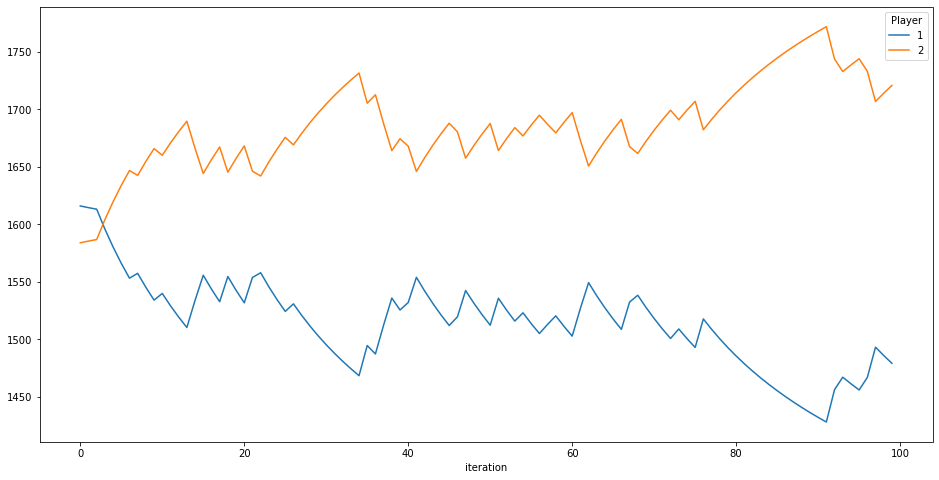

In [10]:
df_all = pandas.concat(list_df)
df_all.pivot("iteration", "Player", "ELO").plot(figsize=(16, 8))

In [13]:
df_scores = pandas.DataFrame(list(scores.items()), columns=["Player", "ELO"]).sort_values("ELO", ascending=False).head(10)
# df_scores["sims"] = 2 * 2**df_scores["Player"]
df_scores

,Player,ELO
1,2,1720.764093
0,1,1479.235907


<AxesSubplot:xlabel='Player'>

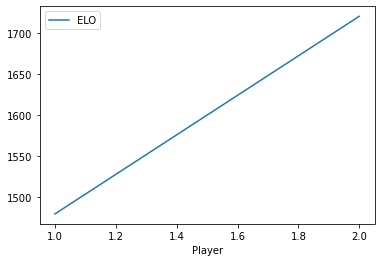

In [12]:
pandas.DataFrame(list(scores.items()), columns=["Player", "ELO"]).plot(x="Player", y="ELO")

In [76]:
# conv501, blank01
results_folder = utils.get_results_folder(trial="conv501")
df_all = pandas.read_csv(os.path.join(results_folder, "all_scores.csv"))
df_fin = pandas.read_csv(os.path.join(results_folder, "fin_scores.csv"))
# df_all = df_all[df_all["Player"].le(72)]

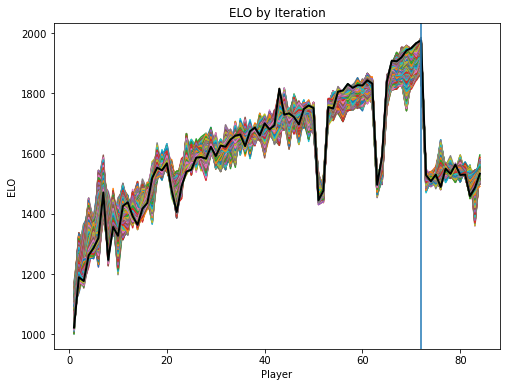

In [78]:
df_all.pivot("iteration", "Player", "ELO").iloc[-500:].T.plot(figsize=(16, 8), legend=False)
df_all.pivot("iteration", "Player", "ELO").iloc[-1].plot(color="k", linewidth=2, figsize=(8,6))
plt.ylabel("ELO")
plt.title("ELO by Iteration")
plt.axvline(72)

<AxesSubplot:xlabel='iteration'>

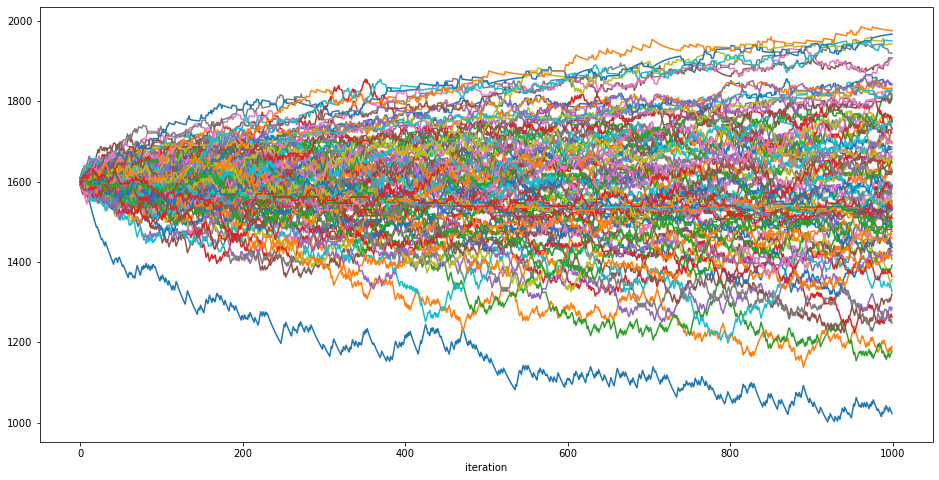

In [79]:
df_all.pivot("iteration", "Player", "ELO").plot(figsize=(16, 8), legend=False)

In [33]:
list_df = []
for file in glob.glob("data/trialconv402/training*/validation-avg-losses-*.pickle"):
    dft = pandas.DataFrame()
    with open(file, "rb") as f:
        dft["Losses"] = pickle.load(f)
    dft["epoch"] = int(file.split("/")[2][8:])
    dft = dft.reset_index().rename(columns={"index": "iteration"})
    list_df.append(dft)

34


Text(0.5, 1.0, 'Traning Validation Losses')

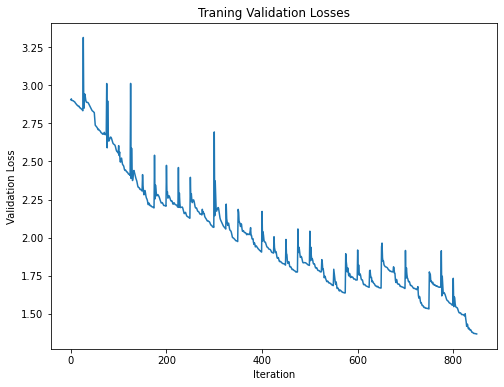

In [34]:
df = pandas.concat(list_df)
print(df["epoch"].max())
df["ai"] = df["epoch"].sub(1).mul(25).add(df["iteration"])
df.sort_values("ai").set_index("ai")["Losses"].plot(figsize=(8, 6))
plt.ylabel("Validation Loss")
plt.xlabel("Iteration")
plt.title("Traning Validation Losses")

In [31]:
start_state = connect_four.start_state().view(1, 1, 6, 7)
data = {}
for file in glob.glob("data/trialconv402/training*/model-*.model"):
    num = int(file.split("/")[2][8:])
    nnet = connect_net.load_model(path=file, log=False, klass=connect_net.ConnectNet4)
    v, proba = nnet(start_state)
    data[num] = proba[0].detach().numpy()

Text(0.5, 0, 'Iteration')

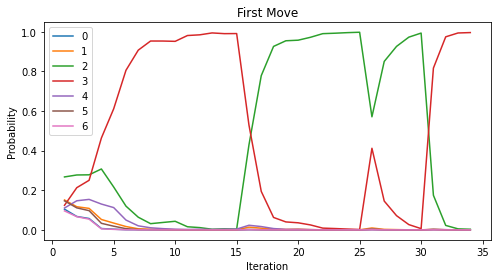

In [36]:
pandas.DataFrame(data).T.sort_index().plot(figsize=(8, 4))
plt.title("First Move")
plt.ylabel("Probability")
plt.xlabel("Iteration")

In [26]:
data_folder = utils.get_data_folder()
boards = np.load(os.path.join(data_folder, "move8_boards.npy"))
winners = np.load(os.path.join(data_folder, "move8_winner.npy"))
boards = torch.Tensor(boards)
winners = torch.Tensor(winners)

In [32]:
trial = "conv401"

list_df_401 = []
for file in glob.glob(f"data/trial{trial}/training*/model-*.model"):
    num = int(file.split("/")[2][8:])
    nnet = connect_net.load_model(path=file, log=False, klass=connect_net.ConnectNet3)
    v, proba = nnet(boards.view(-1,1,6,7))
    df8 = pandas.DataFrame()
    df8["pred"] = v.detach().numpy()
    df8["winners"] = winners.numpy()
    df8["nnet"] = num
    list_df_401.append(df8)
    
trial = "conv402"
list_df_402 = []
for file in glob.glob(f"data/trial{trial}/training*/model-*.model"):
    num = int(file.split("/")[2][8:])
    nnet = connect_net.load_model(path=file, log=False, klass=connect_net.ConnectNet4)
    v, proba = nnet(boards.view(-1,1,6,7))
    df8 = pandas.DataFrame()
    df8["pred"] = v.detach().numpy()
    df8["winners"] = winners.numpy()
    df8["nnet"] = num
    list_df_402.append(df8)

In [33]:
df = pandas.concat(list_df)
df["diff"] = df["winners"]-df["pred"]
df["sq_diff"] = np.square(df["diff"])
df["pred_round"] = df["pred"].round()
df["pred_sign"] = df["pred"] >= 0
df["eq"] = df["pred_round"] == df["winners"]
df["eq_sign"] = df["pred_sign"] == df["winners"]
df = df[df["nnet"].le(72)]

Text(0.5, 0, 'Iteration')

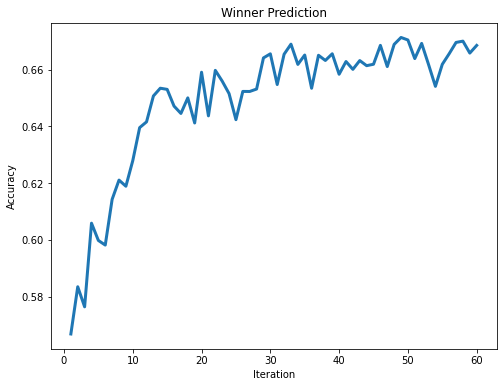

In [34]:
df[df["winners"].ne(0)].groupby("nnet")["eq_sign"].mean().plot(figsize=(8, 6), linewidth=3)
plt.title("Winner Prediction")
plt.ylabel("Accuracy")
plt.xlabel("Iteration")
# plt.axvline(70)

In [28]:

trial = "conv402"
list_df_402 = []
for file in glob.glob(f"data/trial{trial}/training*/model-*.model"):
    num = int(file.split("/")[2][8:])
    print(num)
    nnet = connect_net.load_model(path=file, log=False, klass=connect_net.ConnectNet4)
    v, proba = nnet(boards.view(-1,1,6,7))
    df8 = pandas.DataFrame()
    df8["pred"] = v.detach().numpy()
    df8["winners"] = winners.numpy()
    df8["nnet"] = num
    list_df_402.append(df8)

12
15
23
24
25
22
14
13
7
9
8
1
6
31
30
16
29
11
27
18
20
21
26
19
10
17
28
3
4
5
2
32
33
34


In [29]:
df402 = pandas.concat(list_df_402)
df402["diff"] = df402["winners"]-df402["pred"]
df402["sq_diff"] = np.square(df402["diff"])
df402["pred_round"] = df402["pred"].round()
df402["pred_sign"] = df402["pred"] >= 0
df402["eq"] = df402["pred_round"] == df402["winners"]
df402["eq_sign"] = df402["pred_sign"] == df402["winners"]

Text(0.5, 0, 'Iteration')

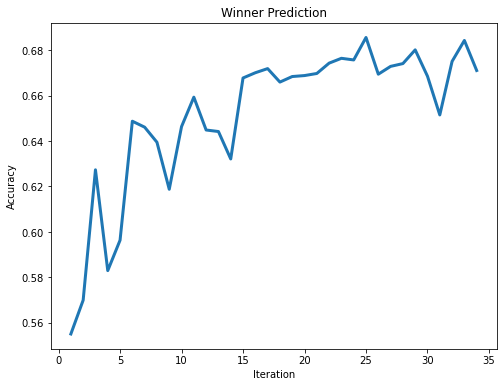

In [30]:
dfplot = df402[df402["winners"].ne(0)].groupby("nnet")["eq_sign"].mean()
dfplot.iloc[1] = 0.57
dfplot.plot(figsize=(8, 6), linewidth=3)
plt.title("Winner Prediction")
plt.ylabel("Accuracy")
plt.xlabel("Iteration")